In [1]:

import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.io import imread
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance
from skimage.io import imread
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from skimage.filters import sobel
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix


2025-05-18 00:34:12.218301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 00:34:12.218911: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 00:34:12.221351: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 00:34:12.227593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747524852.237776    6691 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747524852.24

# Visualization of the new dataset generated from the original dataset (images)

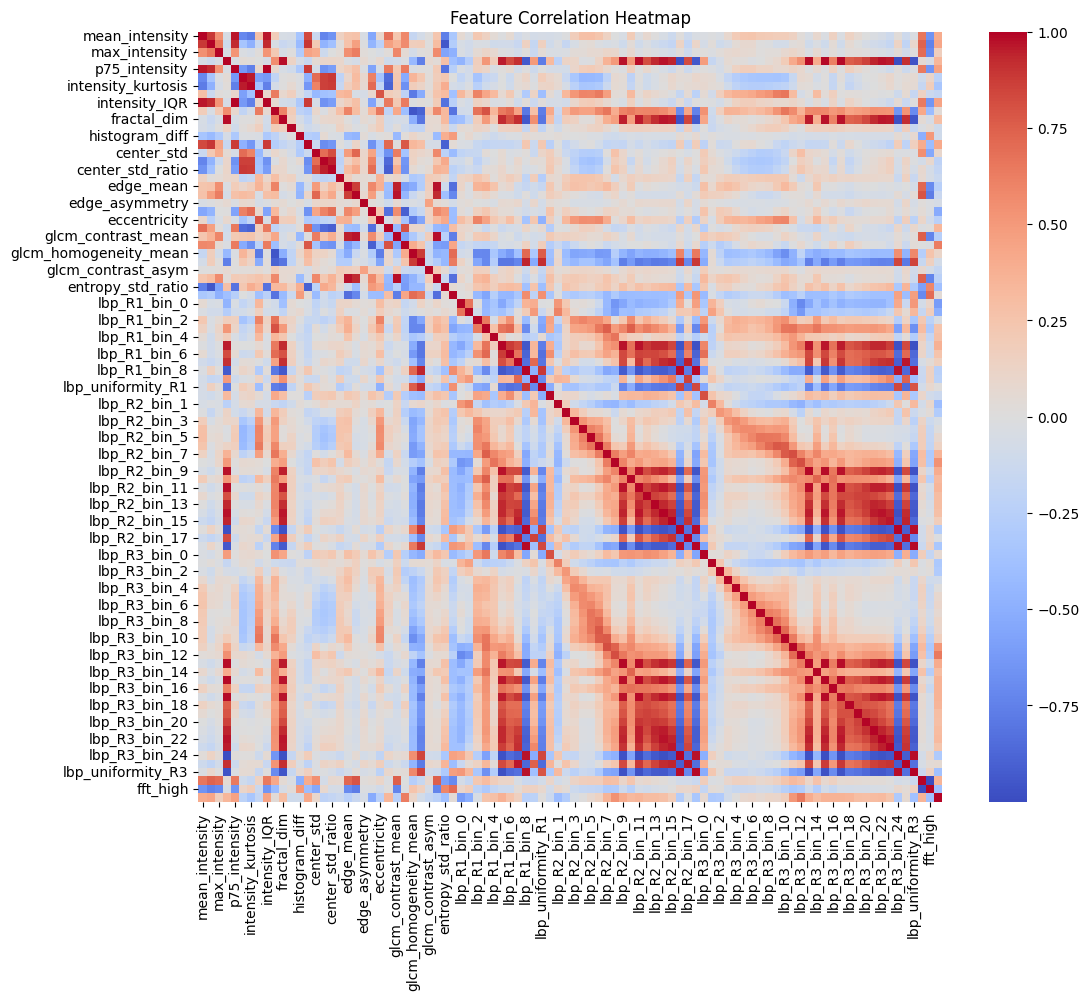

🔍 Dropped 24 highly correlated features.


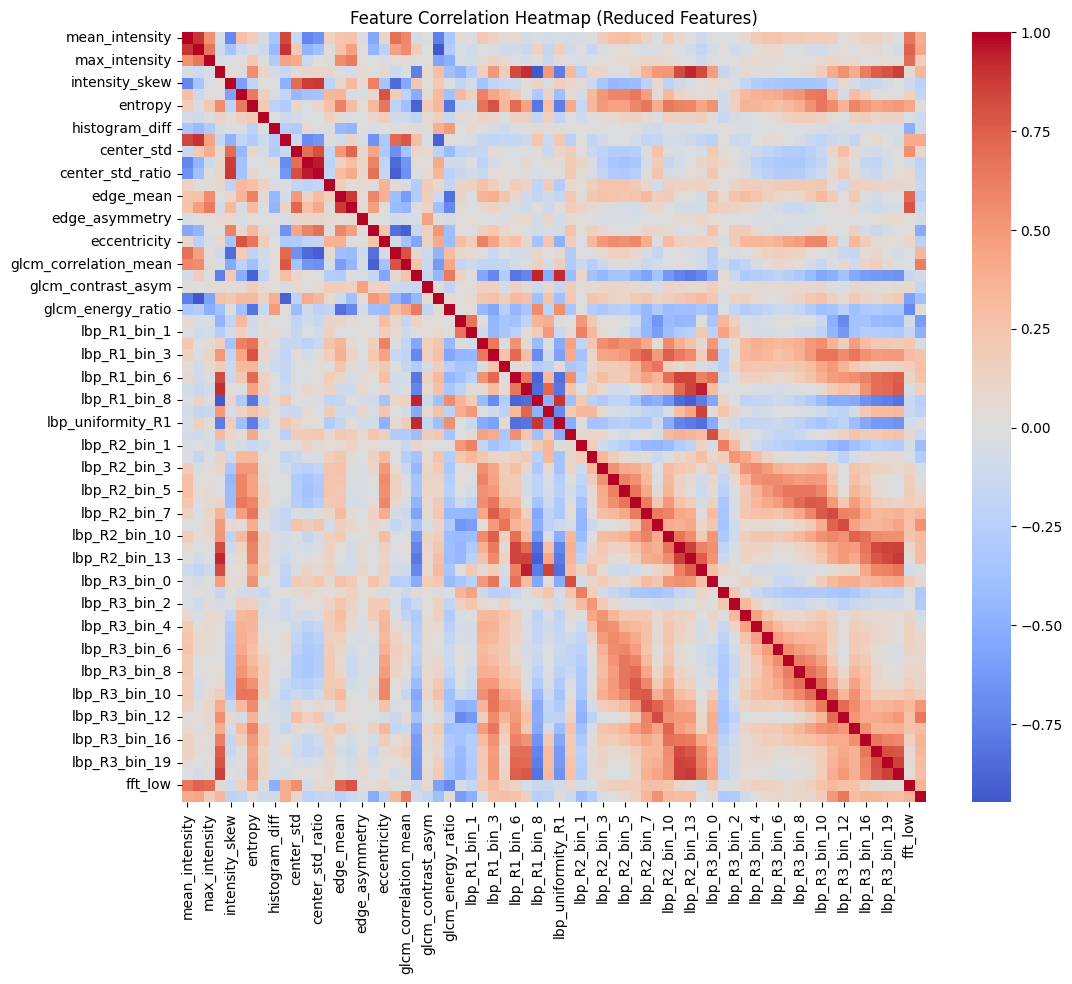

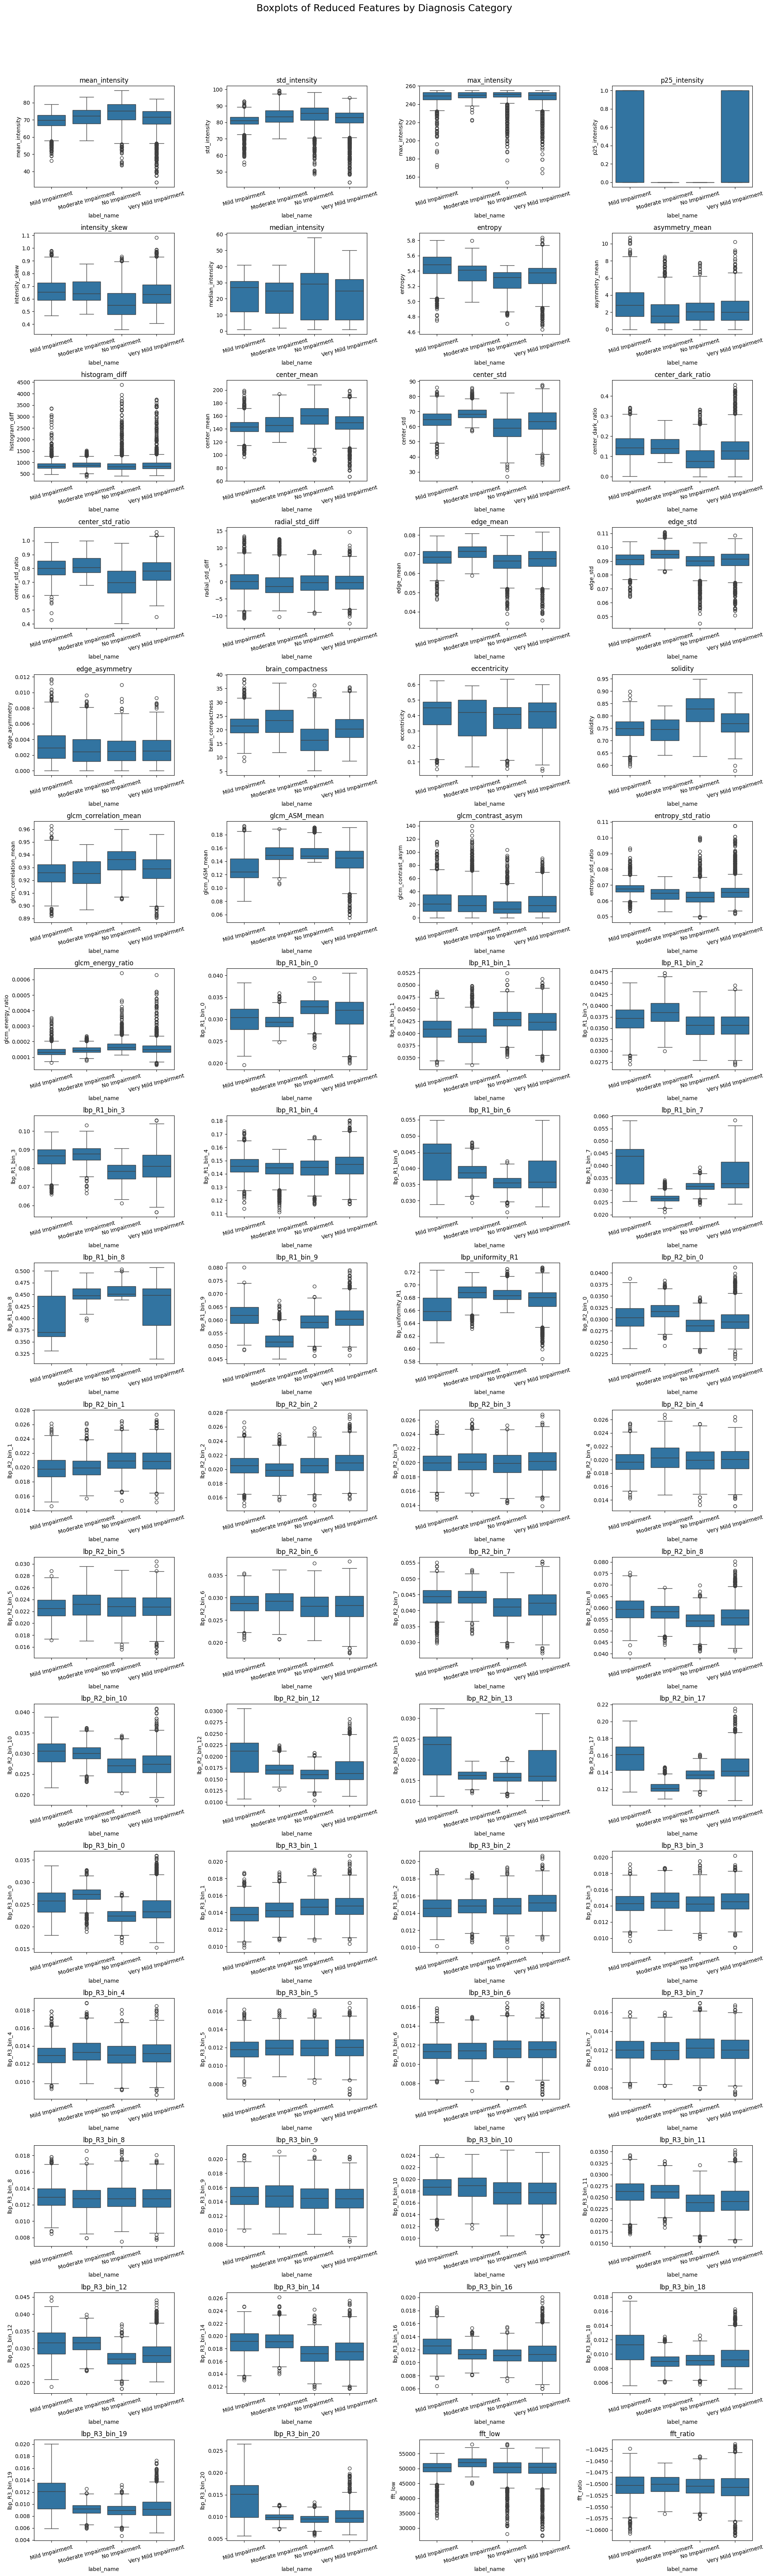

In [2]:
# --- Load Data ---
df = pd.read_csv("train_features.csv")

# --- Label Mapping ---
label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}
df['label_name'] = df['label'].map(label_map)

# --- Feature Selection (drop labels) ---
numeric_features = df.drop(columns=["label", "label_name"])

# --- Correlation Heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Remove Highly Correlated Features ---
corr_matrix = numeric_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
reduced_features = numeric_features.drop(columns=to_drop)

print(f"🔍 Dropped {len(to_drop)} highly correlated features.")

# --- Correlation Heatmap (Reduced Set) ---
plt.figure(figsize=(12, 10))
sns.heatmap(reduced_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Reduced Features)")
plt.show()

# --- Boxplots for All Reduced Features ---
df_reduced = reduced_features.copy()
df_reduced['label_name'] = df['label_name']

n_features = len(reduced_features.columns)
cols = 4  
rows = (n_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, feature in enumerate(reduced_features.columns):
    sns.boxplot(x='label_name', y=feature, data=df_reduced, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=15)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots of Reduced Features by Diagnosis Category", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

🎯 Final selected features (68):
['lbp_R1_bin_1', 'center_mean', 'lbp_R2_bin_13', 'intensity_IQR', 'lbp_R3_bin_23', 'lbp_R2_bin_9', 'lbp_R2_bin_4', 'center_std_ratio', 'solidity', 'lbp_R1_bin_2', 'glcm_homogeneity_mean', 'lbp_R2_bin_14', 'lbp_R2_bin_1', 'texture_richness', 'edge_std', 'lbp_R2_bin_8', 'lbp_R1_bin_6', 'lbp_R1_bin_0', 'asymmetry_mean', 'median_intensity', 'lbp_R3_bin_3', 'std_intensity', 'lbp_R3_bin_7', 'lbp_R1_bin_9', 'fft_low', 'lbp_R2_bin_6', 'lbp_R2_bin_10', 'intensity_skew', 'glcm_contrast_asym', 'lbp_R3_bin_18', 'lbp_R3_bin_16', 'glcm_ASM_mean', 'lbp_R3_bin_8', 'glcm_energy_ratio', 'edge_asymmetry', 'lbp_R3_bin_2', 'brain_compactness', 'lbp_R3_bin_14', 'lbp_R3_bin_20', 'lbp_R2_bin_0', 'center_std', 'center_dark_ratio', 'lbp_R2_bin_3', 'lbp_R3_bin_0', 'histogram_diff', 'lbp_R2_bin_2', 'lbp_R3_bin_11', 'lbp_R3_bin_12', 'lbp_R3_bin_19', 'lbp_R2_bin_17', 'max_intensity', 'lbp_R3_bin_4', 'lbp_R2_bin_12', 'lbp_R3_bin_6', 'lbp_R3_bin_10', 'eccentricity', 'radial_std_diff', 

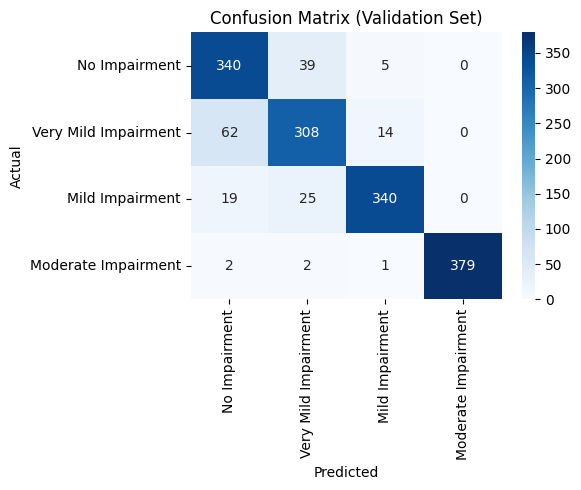


🧪 Test Set Performance
Accuracy: 0.7771696637998436
Balanced Accuracy: 0.5818290270018621
                      precision    recall  f1-score   support

       No Impairment     0.8006    0.8844    0.8404       640
Very Mild Impairment     0.7393    0.7344    0.7368       448
     Mild Impairment     0.7760    0.5419    0.6382       179
 Moderate Impairment     1.0000    0.1667    0.2857        12

            accuracy                         0.7772      1279
           macro avg     0.8290    0.5818    0.6253      1279
        weighted avg     0.7775    0.7772    0.7706      1279



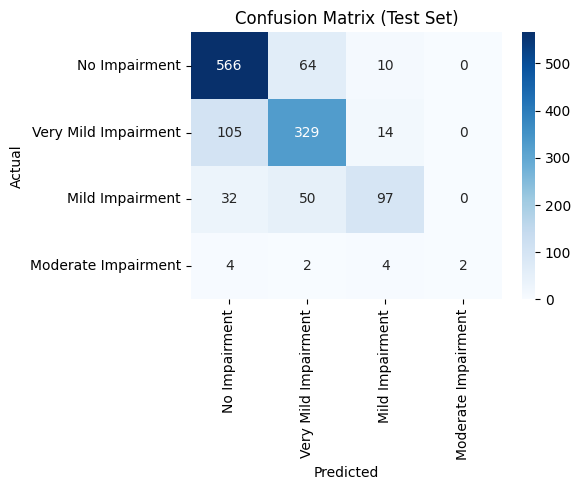

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier

#  Load and filter dataset (3 classes only) 
df = pd.read_csv("train_features.csv")
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

#  Step 1: Feature Selection 
f_scores, pvals = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores, "p_value": pvals})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.sort_values(by="F_score", ascending=False).head(120)["Feature"])
top_mi = set(mi_df.sort_values(by="MI_Score", ascending=False).head(120)["Feature"])
core_features = list(top_f & top_mi)

#  Step 2: Remove Highly Correlated Features 
corr_matrix = X_all[core_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
core_decorrelated = [f for f in core_features if f not in to_drop]

final_features = core_decorrelated

print(f"🎯 Final selected features ({len(final_features)}):\n{final_features}")

#  Load Validation and Test sets 
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

# Define labels
y_val = val_df["label"]
y_test = test_df["label"]

# Extract features
X_train = X_all[final_features]
X_val = val_df[final_features]
X_test = test_df[final_features]

# Grid Search for Best Hyperparameters
param_grid = {
    'max_depth': [8, 12, 16],
    'learning_rate': [0.01, 0.03, 0.05],
    'n_estimators': [300],
    'class_weight': ['balanced']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgbm = LGBMClassifier(random_state=42)

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_all)

print(" Best Parameters:", grid.best_params_)
print("Best CV Balanced Accuracy:", grid.best_score_)
#  Step 4: Train Final Model with Best Parameters 
clf = LGBMClassifier(
    max_depth=grid.best_params_['max_depth'],
    learning_rate=grid.best_params_['learning_rate'],
    n_estimators=grid.best_params_['n_estimators'],
    class_weight=grid.best_params_['class_weight'],
    random_state=42

)
clf.fit(X_train, y_all)

#  Evaluation Utility 
label_map = {
    0: "No Impairment",
    1: "Very Mild Impairment",
    2: "Mild Impairment",
    3: "Moderate Impairment"
}

def evaluate_set(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map.values(), digits=4))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

#  Step 5: Evaluate on Validation and Test Sets 
evaluate_set(X_val, y_val, "Validation Set")
evaluate_set(X_test, y_test, "Test Set")


🎯 Final selected features (68):
['lbp_R1_bin_1', 'center_mean', 'lbp_R2_bin_13', 'intensity_IQR', 'lbp_R3_bin_23', 'lbp_R2_bin_9', 'lbp_R2_bin_4', 'center_std_ratio', 'solidity', 'lbp_R1_bin_2', 'glcm_homogeneity_mean', 'lbp_R2_bin_14', 'lbp_R2_bin_1', 'texture_richness', 'edge_std', 'lbp_R2_bin_8', 'lbp_R1_bin_6', 'lbp_R1_bin_0', 'asymmetry_mean', 'median_intensity', 'lbp_R3_bin_3', 'std_intensity', 'lbp_R3_bin_7', 'lbp_R1_bin_9', 'fft_low', 'lbp_R2_bin_6', 'intensity_skew', 'lbp_R2_bin_10', 'glcm_contrast_asym', 'lbp_R3_bin_18', 'lbp_R3_bin_16', 'glcm_ASM_mean', 'lbp_R3_bin_8', 'glcm_energy_ratio', 'edge_asymmetry', 'lbp_R3_bin_2', 'brain_compactness', 'lbp_R3_bin_14', 'lbp_R3_bin_20', 'lbp_R2_bin_0', 'center_std', 'center_dark_ratio', 'lbp_R2_bin_3', 'lbp_R3_bin_0', 'histogram_diff', 'lbp_R2_bin_2', 'lbp_R3_bin_11', 'lbp_R3_bin_12', 'lbp_R3_bin_19', 'lbp_R2_bin_17', 'max_intensity', 'lbp_R3_bin_4', 'lbp_R2_bin_12', 'lbp_R3_bin_6', 'lbp_R3_bin_10', 'eccentricity', 'radial_std_diff', 

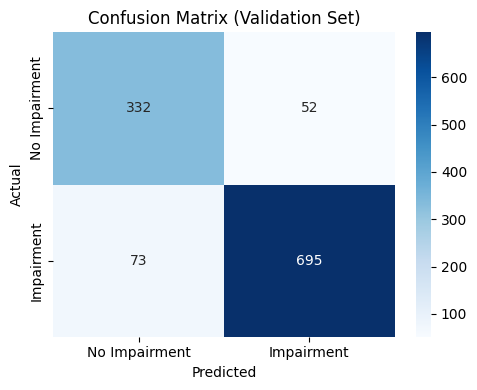


🧪 Test Set Performance (Binary)
Accuracy: 0.8303078137332282
Balanced Accuracy: 0.8299416866028708
               precision    recall  f1-score   support

No Impairment     0.8111    0.8656    0.8375       640
   Impairment     0.8527    0.7943    0.8225       627

     accuracy                         0.8303      1267
    macro avg     0.8319    0.8299    0.8300      1267
 weighted avg     0.8317    0.8303    0.8301      1267



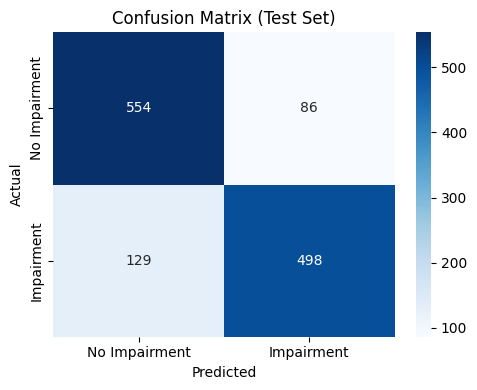

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier

# Load and preprocess dataset
df = pd.read_csv("train_features.csv")
df = df[df["label"] <4]  # Keep classes 0, 1, 2 only

X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

# Binary target: 0 = No Impairment, 1 = Any Impairment
y_all_binary = (y_all > 0).astype(int)

# Custom feature engineering
X_all["texture_richness"] = X_all["glcm_contrast_mean"] * X_all["entropy"]
X_all["center_std_ratio"] = X_all["center_std"] / (X_all["std_intensity"] + 1e-6)

# Feature selection
f_scores, pvals = f_classif(X_all, y_all_binary)
mi_scores = mutual_info_classif(X_all, y_all_binary, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores, "p_value": pvals})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.sort_values(by="F_score", ascending=False).head(100)["Feature"])
top_mi = set(mi_df.sort_values(by="MI_Score", ascending=False).head(100)["Feature"])
core_features = list(top_f & top_mi)

# Remove highly correlated features
corr_matrix = X_all[core_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
final_features = [f for f in core_features if f not in to_drop]

print(f"🎯 Final selected features ({len(final_features)}):\n{final_features}")

# Load and prepare validation/test sets
val_df = pd.read_csv("val_features.csv")
val_df = val_df[val_df["label"] < 3]
test_df = pd.read_csv("test_features.csv")
test_df = test_df[test_df["label"] < 3]

for dataset in [val_df, test_df]:
    dataset["texture_richness"] = dataset["glcm_contrast_mean"] * dataset["entropy"]
    dataset["center_std_ratio"] = dataset["center_std"] / (dataset["std_intensity"] + 1e-6)

X_train = X_all[final_features]
X_val = val_df[final_features]
X_test = test_df[final_features]

y_val = val_df["label"]
y_test = test_df["label"]

# Binary versions
y_val_binary = (y_val > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

# Train binary LightGBM model
clf = LGBMClassifier(
    n_estimators=300,
    max_depth=16,
    class_weight="balanced",
    learning_rate=0.15,
    random_state=42
)
clf.fit(X_train, y_all_binary)

# Evaluation function
label_map_binary = {
    0: "No Impairment",
    1: "Impairment"
}

def evaluate_binary(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance (Binary)")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map_binary.values(), yticklabels=label_map_binary.values())
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

evaluate_binary(X_val, y_val_binary, "Validation Set")
evaluate_binary(X_test, y_test_binary, "Test Set")
